# Measuring the Reliability of MIDI-Derived Annotations

Given that a MIDI file can contain a tantalizing array of information about a piece of music, the question remains as to how reliable this information is in MIDI files found "in the wild".  To attempt to measure this, we can compare MIDI-derived annotations to human-made annotations.  In the following two experiments, we compare key labels and beat locations extracted from MIDI transcriptions of Beatles songs to annotations from the [Isophonics Beatles dataset](http://isophonics.net/content/reference-annotations-beatles).  Key and beat are the two types of annotations which are available both from MIDI files and Isophonics; conveniently, they also represent alignment-independent timing-agnostic information (key) and alignment-dependent, timing-critical information (beat).  As a short summary of our results, we propose that MIDI-derived annotations are useful, but their usage may come with a variety of task-dependent caveats.

In [1]:
import mir_eval
import glob
import pretty_midi
import numpy as np
import collections
import os
import librosa
import vamp
import tabulate
import djitw
import joblib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

## Key evaluation

MIDI files can optionally include key change meta-events.  We found 223 Beatles MIDI files which had a single key annotation and compared them to the Isophonics Beatles annotations using the [MIREX methodology](http://www.music-ir.org/mirex/wiki/2015:Audio_Key_Detection) to compute an accuracy score.  For baselines, we also evaluated handmade annotations from [whatkeyisitin.com](http://whatkeyisitin.com) and the [QM-vamp key estimator](http://vamp-plugins.org/plugin-doc/qm-vamp-plugins.html#qm-keydetector), a high-quality audio content-based key estimation algorithm.  If the MIDI-derived annotations are to be considered reliable, they should achieve accuracy scores on par with the handmade annotations.

In [2]:
# Key loading/computation functions
def load_midi_key(filename):
    ''' Load in key labels from a MIDI file '''
    # Load in MIDI object and grab key change events
    pm = pretty_midi.PrettyMIDI(filename)
    key_changes = pm.key_signature_changes
    # Convert each key change's number to a string (like 'C Major')
    # Also convert it to lowercase, for mir_eval's sake
    return [pretty_midi.key_number_to_key_name(k.key_number).lower()
            for k in key_changes]

def load_isophonics_key(filename):
    ''' Read in key labels from an isophonics lab file '''
    # Isophonics key lab files have three columns:
    # start time, end time, and label
    start, end, labels = mir_eval.io.load_delimited(
        filename, [float, float, str])
    # Extract key labels, which in lab files are formatted as
    # 'key\tC' or 'key\tC:minor'
    keys = [l.split('\t')[1] for l in labels if 'Key' in l]
    # Convert from 'C' and 'C:minor' to 'c major' and 'c minor'
    for n, key in enumerate(keys):
        if 'minor' in key:
            keys[n] = key.replace(':', ' ').lower()
        else:
            keys[n] = key.lower() + ' major'
        # Validate the key early
        mir_eval.key.validate_key(keys[n])
    return keys

def load_vamp_key(filename):
    ''' Estimate the key from an audio file using QM key detector '''
    # Load in audio data at its native sampling rate
    audio_data, fs = librosa.load(filename, sr=None)
    # Create a vamp processor that will generate key labels
    key_generator = vamp.process_audio_multiple_outputs(
        audio_data, fs, 'qm-vamp-plugins:qm-keydetector', ['key'])
    # Grab the key labels produced by the vampplugin
    vamp_output = [out['key'] for out in key_generator]
    keys = [l['label'] for l in vamp_output]
    # Compute the durations of each key in the song
    starts = [float(l['timestamp']) for l in vamp_output]
    starts.append(librosa.get_duration(audio_data, fs))
    durations = np.diff(starts)
    unique_keys = list(set(keys))
    key_durations = [sum(d for k, d in zip(keys, durations) if k == key)
                     for key in unique_keys]
    # Retrieve the key which spanned the most of the song
    most_common_key = unique_keys[np.argmax(key_durations)]
    # Sometimes vamp produces keys like
    # 'Eb / D# minor'
    # so here, we are just retrieving the last part ('D# minor')
    if ' / ' in most_common_key:
        most_common_key = most_common_key.split(' / ')[1]
    return most_common_key

In [3]:
# Keep track of the number of files skipped for different reasons
n_skipped = collections.defaultdict(int)
# Keep track of the weighted accuracy for each file for each source
scores = collections.defaultdict(list)
# Keep track of whether each MIDI estimated key is C major
c_majors = []
for lab_filename in glob.glob('data/isophonics_key/*/*.lab'):
    # Load Isophonics key from .lab file
    try:
        isophonics_keys = load_isophonics_key(lab_filename)
    except Exception as e:
        # Keep track of how many isophonics files which have invalid keys
        n_skipped['Isophonics key was invalid'] += 1
        continue
    # If there are more than 1 Isophonics keys, skip
    if len(isophonics_keys) > 1:
        n_skipped['Isophonics returned more than 1 key'] += 1
        continue
    isophonics_key = isophonics_keys[0]
    
    # Loop over all possible MIDI files for this key
    midi_glob = lab_filename.replace('isophonics_key', 'mid').replace('.lab', '.mid*')
    for midi_filename in glob.glob(midi_glob):
        # Get keys from MIDI file
        try:
            midi_keys = load_midi_key(midi_filename)
        except Exception as e:
            n_skipped['MIDI parsing raised an exception'] += 1
            continue
        # If there's no key change event, skip
        if len(midi_keys) == 0:
            n_skipped['MIDI file had no key annotations'] += 1
            continue
        # If there's multiple key change events, skip
        if len(midi_keys) > 1:
            n_skipped['MIDI file had multiple key annotations'] += len(midi_keys) > 1
            continue
        midi_key = midi_keys[0]
        # Keep track of whether the estimated key was a C major
        c_majors.append(midi_keys[0] == 'c major')
        # Compute and store score for this MIDI file
        scores['midi'].append(mir_eval.key.weighted_score(isophonics_key, midi_key))

    # Construct .wav filename from .lab filename
    audio_filename = lab_filename.replace('isophonics_key', 'wav').replace('.lab', '.wav')
    # Estimate the key using vamp QM key detector plugin
    try:
        vamp_key = load_vamp_key(audio_filename)
    except Exception as e:
        n_skipped['reading the audio file raised an exception'] += 1
        continue
    scores['vamp'].append(mir_eval.key.weighted_score(isophonics_key, vamp_key))

    # Construct whatkeyisitin text filename from .lab filename
    whatkeyisitin_filename = lab_filename.replace('isophonics_key', 'whatkeyisitin_key').replace('.lab', '.txt')
    if not os.path.exists(whatkeyisitin_filename):
        # Keep track of how many are skipped due to missing wkiii annotation
        n_skipped['whatkeyisitin.com did not have an annotation'] += 1
        continue
    with open(whatkeyisitin_filename) as f:
        whatkeyisitin_key = f.read()
    scores['wkiii'].append(mir_eval.key.weighted_score(isophonics_key, whatkeyisitin_key))

In [4]:
# Print the number of files which were skipped for different reasons
for key, value in n_skipped.items():
    print '{} skipped because {}'.format(value, key)
print 'Total isophonics .lab files: {}'.format(len(glob.glob('data/isophonics_key/*/*.lab')))
print
# Pretty-print a table of results
mean_scores = collections.OrderedDict([
    ('MIDI, all keys', np.mean(scores['midi'])),
    ('MIDI, C major only', np.mean([s for c, s in zip(c_majors, scores['midi']) if c])),
    ('MIDI, non-C major', np.mean([s for c, s in zip(c_majors, scores['midi']) if not c])),
    ('QM Vamp Key Detector', np.mean(scores['vamp'])),
    ('whatkeyisitin.com', np.mean(scores['wkiii']))])
n_comparisons = collections.OrderedDict([
    ('MIDI, all keys', len(scores['midi'])),
    ('MIDI, C major only', sum(c_majors)),
    ('MIDI, non-C major', len([c for c in c_majors if not c])),
    ('QM Vamp Key Detector', len(scores['vamp'])),
    ('whatkeyisitin.com', len(scores['wkiii']))])
print tabulate.tabulate(
    [(name, score, num) for (name, score, num) in 
     zip(mean_scores.keys(), mean_scores.values(), n_comparisons.values())],
    ['Source', 'Mean score', '# of comparisons'])

5 skipped because MIDI file had multiple key annotations
221 skipped because MIDI file had no key annotations
7 skipped because Isophonics key was invalid
6 skipped because whatkeyisitin.com did not have an annotation
21 skipped because Isophonics returned more than 1 key
Total isophonics .lab files: 179

Source                  Mean score    # of comparisons
--------------------  ------------  ------------------
MIDI, all keys            0.4                      223
MIDI, C major only        0.167123                 146
MIDI, non-C major         0.841558                  77
QM Vamp Key Detector      0.686755                 151
whatkeyisitin.com         0.857241                 145


From these results, we can see that in general MIDI-derived key annotations are not very reliable (they achieved a score of 0.4, compared to the audio content-based key estimator's ~0.69 or the human-to-human baseline of ~0.86).  However, a suspicious characteristic of MIDI files is the preponderance of C major key annotations - over 65% of the key annotations in our Beatles MIDI files were C major.  If we evaluate non-C major key annotations separately, we achieve a score of 0.84 - very close to the human-to-human baseline.  This suggests that **non-C major annotations are reliable, but C major annotations are not**.  This may be caused by the fact that some MIDI transcription software packages insert C major key change events by default.

## Beat evaluation

Because MIDI files are transcriptions, they contain meter information, so it is possible to extract beat (and downbeat) locations from them.  In order to use these MIDI-derived beats as annotations for an audio recording, the MIDI file must first be aligned in time to the recording.  The reliability of the annotations therefore depends both on the quality of the MIDI file and the quality of the alignment scheme.  To quantify this, we compared aligned MIDI-derived beat annotations to Isophonics and [`madmom`](https://github.com/CPJKU/madmom)'s `DBNBeatTracker`, a start-of-the-art beat tracker which, on the Beatles data, can produce near-perfect annotations.  We will be using the alignment scheme proposed in [_"Optimizing DTW-Based Audio-to-MIDI Alignment and Matching"_](http://colinraffel.com/publications/icassp2016optimizing.pdf), which was found through a large-scale search over possible alignment systems.

In [5]:
# CQT parameters
NOTE_START = 36
N_NOTES = 48

def compute_cqt(audio_data, fs):
    """Compute some audio data's constant-Q spectrogram, normalize,
    and log-scale it"""
    # Compute CQT of the synthesized audio data
    gram = librosa.cqt(
        audio_data, fmin=librosa.midi_to_hz(NOTE_START), n_bins=N_NOTES)
    # Compute log amplitude
    gram = librosa.logamplitude(gram, ref_power=gram.max())
    # Transpose so that rows are samples
    gram = gram.T
    # and L2 normalize
    return librosa.util.normalize(gram, norm=2., axis=1)

def frame_times(gram, fs=22050, hop_length=512):
    """Get the times corresponding to the frames in a spectrogram, which was
    created with the default parameters of librosa.cqt"""
    return librosa.frames_to_time(np.arange(gram.shape[0]), fs, hop_length)

def evaluate_midi(midi_file, audio_file, annotation_file):
    """Align a MIDI file to an audio recording, extract beat 
    annotations, and compare them to handmdae ground truth."""
    # Load in audio data
    audio, fs = librosa.load(audio_file)
    # Load in MIDI data
    pm = pretty_midi.PrettyMIDI(midi_file)
    # Synthesize MIDI
    midi_audio = pm.fluidsynth(fs)
    # Copute log-magnitude, L2-normalized, constant-Q spectrograms
    audio_gram = compute_cqt(audio, fs)
    midi_gram = compute_cqt(midi_audio, fs)
    # Get distance matrix
    distance_matrix = 1 - np.dot(midi_gram, audio_gram.T)
    # Non-diagonal additive path penalty is the median of the sim mtx
    add_pen = np.median(distance_matrix)
    # Get best path through matrix
    aligned_midi_indices, aligned_audio_indices, confidence_score = djitw.dtw(
        distance_matrix, gully=.96, additive_penalty=add_pen,
        inplace=False)
    # Normalize score by path length
    confidence_score /= float(len(aligned_midi_indices))
    # Normalize score by score by mean sim matrix value within path chunk
    confidence_score /= distance_matrix[
        aligned_midi_indices.min():aligned_midi_indices.max(),
        aligned_audio_indices.min():aligned_audio_indices.max()].mean()
    # The confidence score is a normalized DTW distance, which
    # approximately follows in the range [.5, 1.] with .5 meaning a very
    # good alignment.  This maps the scores from [0., 1.] where 1. means a
    # very good alignment.
    confidence_score = np.clip(2*(1 - confidence_score), 0, 1)
    # Adjust MIDI timing
    midi_frame_times = frame_times(midi_gram)
    audio_frame_times = frame_times(audio_gram)
    pm.adjust_times(midi_frame_times[aligned_midi_indices],
                    audio_frame_times[aligned_audio_indices])
    # Get beats from aligned MIDI
    midi_beats = pm.get_beats()
    # Get beats from the Isophonics file
    reference_beats, _ = mir_eval.io.load_labeled_events(annotation_file)
    # Get beat evaluation scores
    beat_scores = mir_eval.beat.evaluate(reference_beats, midi_beats)
    return [confidence_score, beat_scores]

In [6]:
# Retrieve list of MIDI files by globbing
midi_files = glob.glob(os.path.join('data', 'mid', '*', '*.mid*'))
# Assemble audio file list by replacing mid with wav
audio_files = [os.path.splitext(f.replace('mid', 'wav'))[0] + '.wav'
               for f in midi_files]
# Same, replacing with isophonics and .txt
annotation_files = [os.path.splitext(f.replace('mid', 'isophonics_beat'))[0] + '.txt'
                    for f in midi_files]
# Retrieve all scores using joblib in parallel for speed
score_list = joblib.Parallel(n_jobs=10, verbose=0)(
    joblib.delayed(evaluate_midi)(*args)
    for args in zip(midi_files, audio_files, annotation_files))

In [7]:
# Load in DBNBeatTracker annotations for comparison
# They can be generated by running
#    mkdir dbn_annotations; DBNBeatTracker batch wav/*/*.wav -o dbn_annotations/
# and then un-flattening the directory structure and renaming .beats.txt to .txt
dbn_scores = []
# Get a list of all of the DBNBeatTracker output files
dbn_files_glob = glob.glob(os.path.join('data', 'dbn_annotations', '*', '*.txt'))
for dbn_file in dbn_files_glob:
    # Get isophonics ground truth filename path
    ground_truth_beats_file = dbn_file.replace('dbn_annotations', 'isophonics_beat')
    # Skip in case Isophonics did not annotate this file
    if not os.path.exists(ground_truth_beats_file):
        continue
    # Load in reference beats and estimated beats
    ref_beats, _ = mir_eval.io.load_labeled_events(ground_truth_beats_file)
    est_beats = mir_eval.io.load_events(dbn_file)
    # Compute beat evaluation metrics
    dbn_scores.append(mir_eval.beat.evaluate(ref_beats, est_beats))

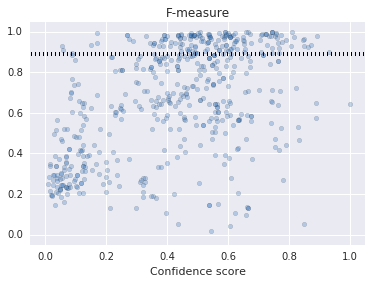

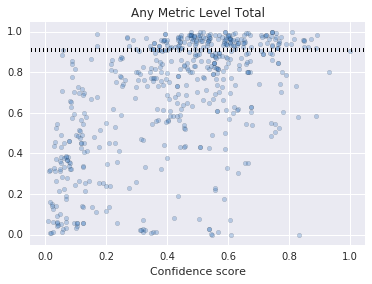

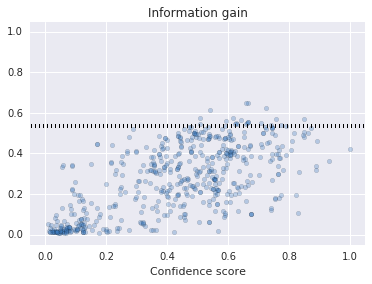

In [8]:
# Create array of confidence scores output by evaluate_midi function
confidence_scores = np.array([s[0] for s in score_list])
# Plot these three metrics
for n, metric in enumerate(['F-measure', 'Any Metric Level Total', 'Information gain']):
    plt.figure(figsize=(6, 4))
    # Get metric scores achieved by MIDI files
    midi_beat_scores = np.array([s[1][metric] for s in score_list])
    # Plot confidence on x axis, metric score in y axis
    points = plt.scatter(confidence_scores, midi_beat_scores, c='#3778bf', alpha=.3)
    # Also plot line showing the DBNBeatTracker mean score
    dbn_mean = np.mean([s[metric] for s in dbn_scores])
    plt.plot([-1, 2.], [dbn_mean, dbn_mean], 'k:', lw=4)
    plt.axis([-0.05, 1.05, -0.05, 1.05])
    plt.title(metric)
    plt.xlabel('Confidence score')

In these plots, each blue point corresponds to a MIDI file.  We don't expect every MIDI file to produce valid beat annotations (for example, if it is a bad transcription or the alignment failed), so we plot both the alignment confidence score (on the x-axis) and the beat evaluation metric score (on the y-axis).  Ideally, we'd like all points to be clustered in the bottom left (corresponding to bad annotations with low confidence scores) or top right (successful alignments with high confidence scores).  While this pattern does show up to some extent, there clearly are many MIDI files which produced poor annotations and had high confidence scores.  This problem is exacerbated by the fact that beat evaluation metrics are sensitive to small-scale timing errors and differences in metric level, which are both common issues in aligned MIDI files.  We therefore propose that **developing more precise MIDI-to-audio schemes with better confidence score reporting** will help leverage meter information from MIDI files.